# Project 02

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

----------------

**This project is on machine translation for two "artificial" languages: an "Input Language" and an "Output Language". We want to build a model to translate the texts in the "Input Language" to texts in the "Output Language". For example, a text in the "Input Language" can be "a g b f a f a e a k a j c f b f c d a k a k c e b g a h a k b d b f b f b d c d " , and its translation to the "Output Language" is "b f c f b f c d a j e f g c e b g a k i j b d b f a k l m b f b d a h ed ee ef a k k eg a k h eh a e ei c d a f ej ek a g d el".**

# Initialization

**This section includes mounting the session to Google Drive, importing necessary libraries to run the file, and downloading and reformatting the training datasets.**

## Mount Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import pickle
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

rng = np.random.default_rng()

## Import Data

Download training inputs and outputs.

In [3]:
train_input = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/DS_5_train_input', 'rb'))
train_output = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/DS_5_train_output', 'rb'))

## Vectorize Data

Convert strings of word elements into an integer token vector that indexes the word elements from the defined library of words.

In [4]:
def vectorize_data(train_input,train_output):

  train_output_start = []
  train_output_end = []

  for i in range(0,len(train_output)):
    train_output_start.append("start " + train_output[i])
    train_output_end.append(train_output[i]+"end")
    train_output[i] = "start " + train_output[i] + "end"

  source_vectorization = layers.TextVectorization(output_sequence_length=200)
  target_vectorization = layers.TextVectorization(output_sequence_length=200)
  source_vectorization.adapt(train_input)
  target_vectorization.adapt(train_output)

  train_input = source_vectorization(train_input)
  train_output = target_vectorization(train_output)
  train_output_end = target_vectorization(train_output_end)
  train_output_start = target_vectorization(train_output_start)

  return train_input, train_output, train_output_end, train_output_start

In [5]:
train_input, train_output, train_output_end, train_output_start = vectorize_data(train_input,train_output)

# Transformer Model

## Encoder

In [6]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

## Decoder

In [7]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

## Positional Embedding

In [8]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

## Network Architecture

In [9]:
embed_dim = 256
num_heads = 8
dense_dim = 1000

vocab_size_source = 13
vocab_size_output = 38
sequence_length = 200

encoder_inputs = keras.Input(shape=(None,))
x = PositionalEmbedding(sequence_length, vocab_size_source, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,))
x = PositionalEmbedding(sequence_length, vocab_size_output, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size_output, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   54528       ['input_1[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, None, 256)   60928       ['input_2[0][0]']            

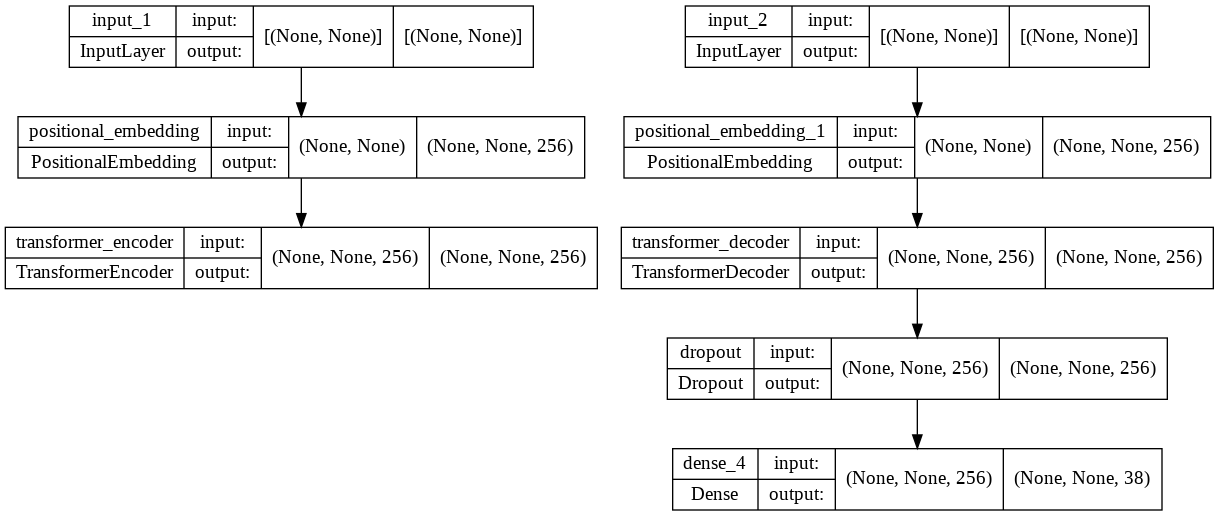

In [10]:
transformer.summary()
tf.keras.utils.plot_model(transformer, show_shapes=True)

## Compilation

In [11]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/transformer.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True)
]

history = transformer.fit(x=[train_input,train_output_start],y=train_output_end,epochs=100,batch_size=64,validation_split=.2,callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 23s 258ms/step - loss: 1.2153 - accuracy: 0.1146 - val_loss: 0.8381 - val_accuracy: 0.1655
Epoch 2/100
63/63 [==============================] - 15s 231ms/step - loss: 0.7304 - accuracy: 0.2528 - val_loss: 0.5703 - val_accuracy: 0.3449
Epoch 3/100
63/63 [==============================] - 15s 232ms/step - loss: 0.6077 - accuracy: 0.3084 - val_loss: 0.5437 - val_accuracy: 0.3362
Epoch 4/100
63/63 [==============================] - 14s 230ms/step - loss: 0.5568 - accuracy: 0.3445 - val_loss: 0.5143 - val_accuracy: 0.3745
Epoch 5/100
63/63 [==============================] - 14s 230ms/step - loss: 0.5318 - accuracy: 0.3636 - val_loss: 0.4823 - val_accuracy: 0.4043
Epoch 6/100
63/63 [==============================] - 14s 220ms/step - loss: 0.5071 - accuracy: 0.3799 - val_loss: 0.4835 - val_accuracy: 0.3940
Epoch 7/100
63/63 [==============================] - 14s 220ms/step - loss: 0.4932 - accuracy: 0.3924 - val_loss: 0.4833 - val_accuracy:

## Vizualize Loss

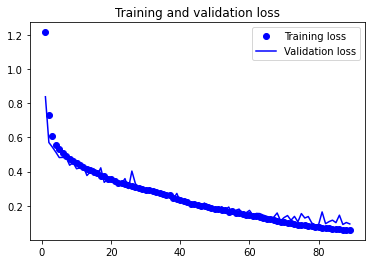

In [12]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# RUN THIS SECTION

**This section evaluates the model and makes predictions.**

## Import Libraries

In [13]:
import pickle
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
rng = np.random.default_rng()

## Encoder

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

## Decoder

In [15]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

## Positional Embedding

In [16]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

## Vectorize vocabularies

In [17]:
encoder_vectorize = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=200, vocabulary= ['', '[UNK]', 'a', 'b', 'c', 'e', 'g', 'd', 'f', 'k', 'i', 'j', 'h'])
decoder_vectorize = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=200, vocabulary= ['', '[UNK]', 'a', 'b', 'c', 'e', 'g', 'd', 'f', 'k', 'i', 'j', 'h', 'start', 'm', 'l', 'end', 'eh', 'eg', 'ef', 'ee', 'ed', 'ei', 'ej', 'ek', 'el', 'em', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'gd'])
inverse_vectorize = dict(zip(range(38), ['', '[UNK]', 'a', 'b', 'c', 'e', 'g', 'd', 'f', 'k', 'i', 'j', 'h', 'start', 'm', 'l', 'end', 'eh', 'eg', 'ef', 'ee', 'ed', 'ei', 'ej', 'ek', 'el', 'em', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'gd']))

## Decode vocabulary

In [18]:
def decode_sequence(input_chunk):
  encoded_chunk = encoder_path(input_chunk)
  decoded_chunk = np.asarray(["start"])
  decoded_chunk = np.repeat(decoded_chunk,input_chunk.shape[0])
  for i in range(0, 200):
    predictions = decoder_path([decoder_vectorize(decoded_chunk),encoded_chunk])
    sampled_token_index = np.argmax(predictions[:, i, :], axis=1)
    sampled_token = np.vectorize(inverse_vectorize.get)(sampled_token_index)
    decoded_chunk = np.char.add(decoded_chunk, " ")
    decoded_chunk = np.char.add(decoded_chunk, sampled_token)
  return decoded_chunk

## Load transformer model

In [19]:
transformer = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/transformer.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding,
                    "TransformerDecoder": TransformerDecoder})

In [20]:
test_input = encoder_vectorize(pickle.load(open("/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/DS_5_train_input",'rb')))
test_output = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_2/DS_5_train_output",'rb')) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   54528       ['input_1[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, None, 256)   60928       ['input_2[0][0]']            

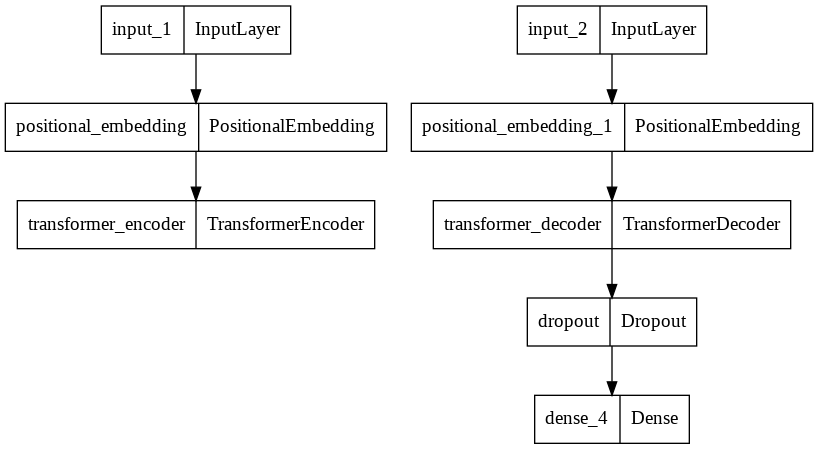

In [21]:
transformer.summary()
tf.keras.utils.plot_model(transformer)

In [22]:
encoder_input = transformer.get_layer("input_1").input
encoder_ouput = transformer.get_layer("transformer_encoder").output
encoder_path = keras.Model(encoder_input,encoder_ouput)

decoder_input = transformer.get_layer("input_2").input
x = transformer.get_layer("positional_embedding_1")(decoder_input)
encoder_output = transformer.get_layer("transformer_encoder").output
x = transformer.get_layer("transformer_decoder")(x,encoder_output)
x = transformer.get_layer("dropout")(x)
decoder_ouput = transformer.get_layer("dense_4")(x)
decoder_path = keras.Model([decoder_input,encoder_output],decoder_ouput)

## Predict an example

In [26]:
i = 2
ans = decode_sequence(test_input[0:100])

In [27]:
print(test_output[i])
print(ans[i][6:])

c f b e c d b f b e a k g h b e a k i j b d c d a h k l m c d a e ee a h f ed ef a g e eg b f a d eh ei a k d ej 
c f b e c d b f b e a k g h b e a k i j b d c d a h k l m c d a e ee a h f ed ef a g e eg b f a d eh ei a k d ej end e ek end el a end d em end fd a k d fe end ff a end d fg end fh a end d fi end fj a end fk a end d fl end end fm end d gd end end end end end end end end end fk end end end end end end end end end a k fe end g j d g j d g k g j fe end g j ff end c b b b b end end end a k g k g j d g j d e eh end c b b e ei end c b e ej end end b end end end end end end c end end end a e ei end end end end a e ej end end end i d g k g k g j d
